In [86]:
from cProfile import label
from os import times
from tokenize import cookie_re
from xmlrpc.client import boolean
from numpy.core.shape_base import atleast_2d
from numpy.lib import type_check
from scipy import fftpack
import math
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal

HPC_OR_LOCAL = "LOCAL"
# "HPC" -> no graph
# "LOCAL" -> graph

# detects the first downward zerocross point


def getDownwardZeroCrossIndex(vector1d):
    downCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            downCount=downCount + 1
        else:
            downCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] < 0 and vector1d[searchIndex-1] > 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] < vector1d[searchIndex-5+i+1]:
                    downCount = 0
                else:
                    downCount = downCount+1
            if downCount == 10:
                # print(searchIndex)
                return searchIndex

# detects the first upward zerocross point


def getUpwardZeroCrossIndex(vector1d):
    upCount = 0
    searchIndex = 1
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
            if upCount == 10:
                # print(searchIndex)
                return searchIndex


def getUpwardZeroCrossIndexFromArbitraryPoint(vector1d, startIndex):
    upCount = 0
    searchIndex = startIndex
    """
    for i in range(10):
        #downcount counter until datapoint 10
        searchIndex = searchIndex + i
        if data[searchIndex] - data[searchIndex-1] < 0:
            upCount=upCount + 1
        else:
            upCount = 0
    """
    while True:
        searchIndex = searchIndex + 1
        if vector1d[searchIndex] > 0 and vector1d[searchIndex-1] < 0:
            for i in range(10):
                if vector1d[searchIndex-5+i] > vector1d[searchIndex-5+i+1]:
                    upCount = 0
                else:
                    upCount = upCount+1
                if upCount == 10:
                    # print(searchIndex)
                    return searchIndex


# Reads the csv file where time series data of detector coorinate is saved.
def loadCsvOutput(csvData):
    ndarrayData = np.loadtxt(csvData, delimiter=",")

    # Several timesteps are recorded twice in the raw csv file.
    # Below is the script which deletes the double-recorded timesteps.
    timeAtTheRowAbove = -100
    delRows = []
    for i in range(len(ndarrayData)):
        if timeAtTheRowAbove == ndarrayData[i, 0]:
            delRows.append(i)
        timeAtTheRowAbove = ndarrayData[i, 0]
    ndarrayData = np.delete(ndarrayData, delRows, 0)

    return ndarrayData

# Withdraws the time series of the detector's x coorinate


def getDetector(array):
    return array[:, 2]

# Withdraws the time series of the source's x coorinate


def getSource(array):
    return array[:, 1]

# trims the wave within the specified range


def trim(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    return trimmedArray

# trims the wave within the specified range and then offsets the wave so that the normal position can be x=0.


def trimAndOffset(vector1d, trimStartTimestep, trimRange):
    trimmedArray = vector1d[trimStartTimestep:trimStartTimestep+trimRange]
    offsettedArray = trimmedArray - vector1d[0]
    return offsettedArray

# performs fft. output[0] = power, output[1] = freq. both output are recognized as complex.


def fftWithWindow(FFTData, hannORhamming: str):
    dataPoints = len(FFTData)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    # print("acf")
    # print(acf)
    waveToTransform = acf*windowFunction*FFTData
    if HPC_OR_LOCAL == "LOCAL":
        plt.plot(waveToTransform)
        plt.show()
    FFT_power = np.fft.fft(waveToTransform, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(dataPoints, d=timeStep*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# under development


def window(data, hannORhamming: str):
    dataPoints = len(data)
    if hannORhamming == "hann":
        windowFunction = signal.hann(dataPoints)
    elif hannORhamming == "hamming":
        windowFunction = signal.hamming(dataPoints)
    else:
        raise Exception(
            "Window is not/wrongly specified. Either hann / hamming is right.")
    acf = 1/(sum(windowFunction)/dataPoints)
    waveToTransform = acf*windowFunction*data
    return waveToTransform


def FFTonly(data):
    FFT_power = np.fft.fft(data, n=None, norm=None)
    FFT_freq = np.fft.fftfreq(len(data), d=timeStep*(10**-12))
    return np.stack([FFT_power, FFT_freq])

# calculates beta.


def getBetaSHG(Amp1, Amp2, Lambda, DeltaX):
    beta = 8*Amp2*Lambda*Lambda/DeltaX/Amp1/Amp1/np.pi/np.pi/2/2
    return beta

# attaches zeros to the raw wave data.


def zeroPadding(data):
    zeros = np.zeros(len(data))
    buffer = 0
    for i in range(50):
        if len(data) < 2**i:
            buffer = 2**(i+4) - len(data)
            break
    zeros = np.zeros(int(buffer/2))
    paddedData = np.hstack((zeros, data, zeros))
    acf = (sum(np.abs(data)) / len(data)) / \
        (sum(np.abs(paddedData)) / len(paddedData))
    return acf*paddedData

# searches the 1d array data for the input value,
# and returns the index of the array where the nearest value of the input value is contained.


def getIndexOfNearestValue(data, value):
    index = np.argmin(np.abs(np.array(data) - value))
    return index

# searches the FFT-performed 1d array of frequencies, and returns the index of 1st - 6th harmonics.


def getIndexUpToSixthHarmonic(data, frequency):
    index1 = getIndexOfNearestValue(data, frequency)
    index2 = getIndexOfNearestValue(data, frequency*2)
    index3 = getIndexOfNearestValue(data, frequency*3)
    index4 = getIndexOfNearestValue(data, frequency*4)
    index5 = getIndexOfNearestValue(data, frequency*5)
    index6 = getIndexOfNearestValue(data, frequency*6)
    return np.array([index1, index2, index3, index4, index5, index6], dtype=np.int64)


def getBetaFreqMix(aSum, aDif, aF1, aF2, freq1, freq2, DeltaX, vel):
    aMix = (aSum+aDif)/2
    Lambda1 = vel/freq1
    Lambda2 = vel/freq2
    K1 = 2*math.pi/Lambda1
    K2 = 2*math.pi/Lambda2
    return np.array([4*aDif/DeltaX/aF1/aF2/K1/K2,4*aSum/DeltaX/aF1/aF2/K1/K2,4*aMix/DeltaX/aF1/aF2/K1/K2])




In [87]:
data1 = loadCsvOutput("outp_1.csv")

In [88]:
data = data1
#print(data)

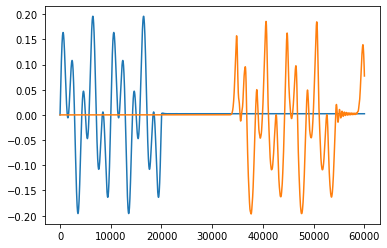

In [89]:
detecNum=23
plt.plot(data[:,1]-data[0,1])
plt.plot(data[:,detecNum]-data[0,detecNum])
plt.show()

data[:,23]まで使える波形っぽい：すなわちdata[:,1]~data[:,23]までの23個の時系列データに対してFFTを行えばよい．

とりあえず23番にFFTするプログラムを作る

44268


<function matplotlib.pyplot.show(close=None, block=None)>

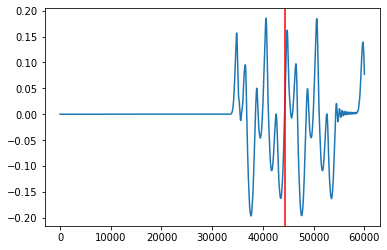

In [90]:
timeStep = data1[1, 0] - data1[0, 0]
time = data[:, 0]
x_detec = data[:, 23]
u_detec= x_detec - x_detec[0]
x_source = data[:, 1]
TLCM = 10
T1 = 2
T2 = 5
inputFreq1 = 10**12 / T1  # [Hz]
inputFreq2 = 10**12/T2
# wave amplitude at the source
source_amp = 0.1  # [Å]

Nc = 1

# Ns: Number of data points in one cycle
Ns = TLCM/timeStep

# N: Total Number of data points in thw windowed region
N = int(Nc*Ns)

zeroCrossTimeStep = getUpwardZeroCrossIndexFromArbitraryPoint(u_detec, 44000)
print(zeroCrossTimeStep)
plt.plot(u_detec)
plt.axvline(x=zeroCrossTimeStep,color="red")
plt.show

とりあえずゼロクロス方でうまくいったけど，探索をどこから始めるかが目視・人力で決めてるのが難点．あとで改善しよう．とりあえず今は23番でフーリエ変換できる方が優先．

In [91]:
arrivalTimeStep = int(zeroCrossTimeStep - TLCM/timeStep)
print(arrivalTimeStep)

34268


x_detec1


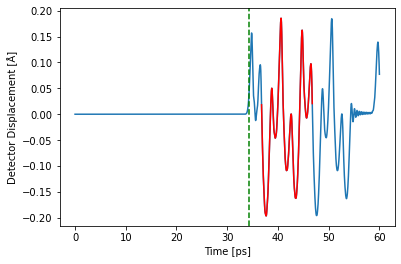

timeStep Δt is:
0.001
trimmed and offseted form of superimposed wave


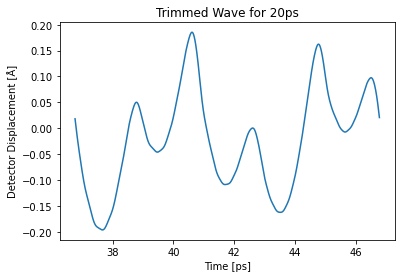

Windowed Wave


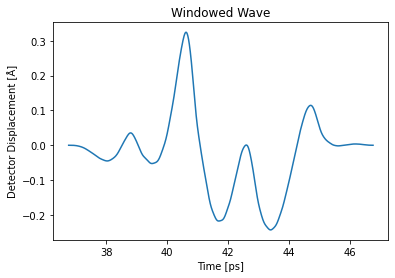

padded wave


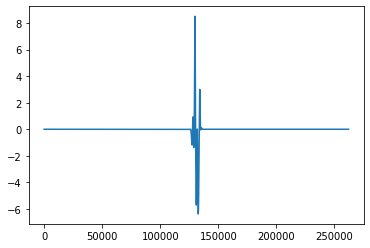


timeStep Δt is:
0.001
wave velocity v[m/s] is:
5499.829160143662
wave length λ1 is:
1.0999658320287324e-08


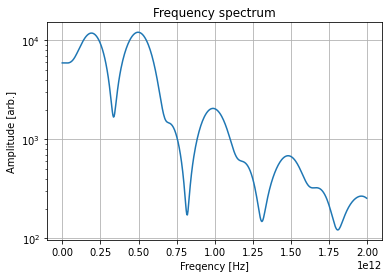

9.202509341726647e-12 9.003864081433232e-12 1.1127446972631557e-12 3.2315969067171407e-12
beta(SHG):
41.08031056337735
beta(FreqMix): f1-f2, f1+f2, ave 
[5.25506243 1.80949017 3.5322763 ]


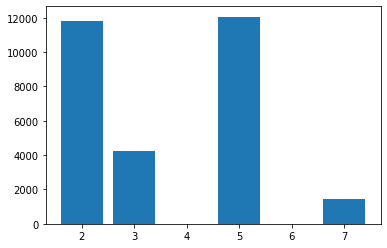

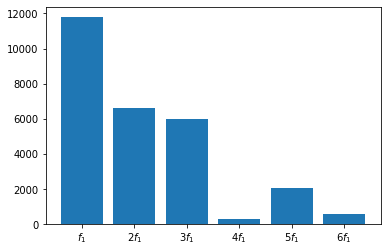

In [92]:
windowStartTimeStep = int(arrivalTimeStep + T2/timeStep/2)
delta_x = x_detec[0] - x_source[0]

waveVelocity = delta_x*(10**(-10)) / ((arrivalTimeStep * timeStep)*(10**(-12)))
waveLength1 = waveVelocity * T1 * (10**(-12))
waveLength2 = waveVelocity * T2 * (10**(-12))


trimmedWave = trimAndOffset(x_detec, windowStartTimeStep, N)
trimmedTime = trim(time, windowStartTimeStep, N)
windowedWave = window(trimmedWave, "hann")
paddedWave = zeroPadding(windowedWave)
paddedWaveWithoutWindow = zeroPadding(trimmedWave)

##SUPER IMPORTANT##
waveToTransform = paddedWave
##CHOU DAIJI##

# FFT. transformedArray: [0]=power, [1]=freq
# FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
#FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
FFTedData = FFTonly(waveToTransform)
#FFTedData=FFTonly(window(trimmedWave, "hann"))
absFFTData = np.abs(FFTedData)

# higher harmonics amplitude[arb]
harmonicsIndex = getIndexUpToSixthHarmonic(absFFTData[1], inputFreq2)
A1 = absFFTData[0][harmonicsIndex[0]]
A2 = absFFTData[0][harmonicsIndex[1]]
A3 = absFFTData[0][harmonicsIndex[2]]
A4 = absFFTData[0][harmonicsIndex[3]]
A5 = absFFTData[0][harmonicsIndex[4]]
A6 = absFFTData[0][harmonicsIndex[5]]
Af1 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq1)]
Af2 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq2)]
Afsum = absFFTData[0][getIndexOfNearestValue(
    absFFTData[1], inputFreq1+inputFreq2)]
Afdif = absFFTData[0][getIndexOfNearestValue(
    absFFTData[1], inputFreq1-inputFreq2)]

af1_0 = source_amp*10**-10
af2_0 = source_amp*10**-10

af1 = Af1*2/int(len(waveToTransform))*10**-10
af2 = Af2*2/int(len(waveToTransform))*10**-10
asum = Afsum*2/int(len(waveToTransform))*10**-10
adif = Afdif*2/int(len(waveToTransform))*10**-10

a1s = source_amp*10**-10
a2 = 2*A2/int(len(waveToTransform))*10**-10

betaSHG = getBetaSHG(a1s, a2, waveLength2, delta_x*(10**-10))
"""with open("betaSHG.txt", "w") as f:
    f.write(str(betaSHG))
"""
betaFreqMix = getBetaFreqMix(
    asum, adif, af1_0, af2_0, inputFreq1, inputFreq2, delta_x*10**-10, waveVelocity)
"""with open("betaFreqMix.txt", "w") as f:
    f.write(str(betaFreqMix))
"""

# drawings
if HPC_OR_LOCAL == "LOCAL":
    fig = plt.figure()
    print("x_detec1")
    y = u_detec
    time_red = time[windowStartTimeStep:windowStartTimeStep+N]
    y_red = y[windowStartTimeStep:windowStartTimeStep+N]
    time1 = time[:windowStartTimeStep]
    y1 = y[:windowStartTimeStep]
    time2 = time[windowStartTimeStep+N:]
    y2 = y[windowStartTimeStep+N:]
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.plot(time, y)
    plt.plot(time_red,y_red, color ="red")
    plt.axvline(x=arrivalTimeStep*timeStep, color="green", linestyle="--")
    #plt.axvline(x=windowStartTimeStep*timeStep, color="red")
    #plt.axvline(x=(windowStartTimeStep+N)*timeStep, color="red")
    plt.show()


    print("timeStep Δt is:")
    print(timeStep)

    print("trimmed and offseted form of superimposed wave")
    plt.title("Trimmed Wave for 20ps")
    plt.plot(trimmedTime, trimmedWave)
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("Windowed Wave")
    plt.plot(trimmedTime, windowedWave)
    plt.title("Windowed Wave")
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("padded wave")
    plt.plot(paddedWave)
    plt.show()


    print()
    print("timeStep Δt is:")
    print(timeStep)

    print("wave velocity v[m/s] is:")
    print(waveVelocity)

    print("wave length λ1 is:")
    print(waveLength1)

    fig, ax = plt.subplots()
    ax.set_yscale("log")
    #ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
    ax.plot(absFFTData[1, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4],
            absFFTData[0, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4])
    ax.set_xlabel("Freqency [Hz]")
    ax.set_ylabel("Amplitude [arb.]")
    ax.grid()
    plt.title("Frequency spectrum")
    plt.show()

    print(af1, af2, asum, adif)

    print("beta(SHG):")
    print(betaSHG)

    print("beta(FreqMix): f1-f2, f1+f2, ave ")
    print(betaFreqMix)

    x_bar = np.array([inputFreq2, inputFreq1-inputFreq2,
                      inputFreq1, inputFreq1+inputFreq2])
    y_bar = np.array([Af2, Afdif, Af1, Afsum])
    x_bar = x_bar / 10**11
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()

    x_bar = np.array(["$f_1$", "$2f_1$", "3$f_1$",
                      "4$f_1$", "5$f_1$", "6$f_1$"])
    y_bar = np.array([A1, A2, A3, A4, A5, A6])
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()



23番やばいな．無能すぎる．
10ps=10*10**-12s でFFTしたので，分解能は
10^11Hz = 100GHz．したがってパディングは効果なし．
もうちょい長くしてみるか．

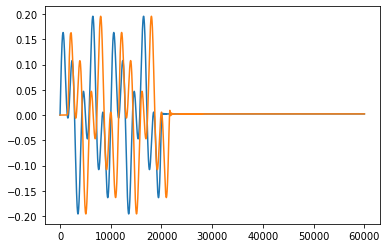

11551


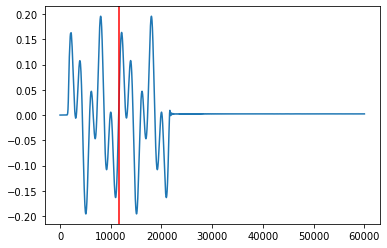

1551
x_detec1


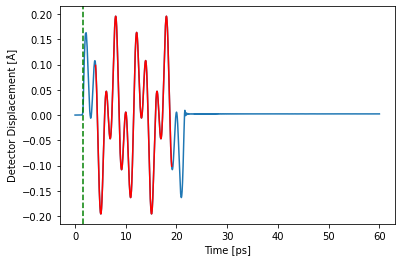

timeStep Δt is:
0.001
trimmed and offseted form of superimposed wave


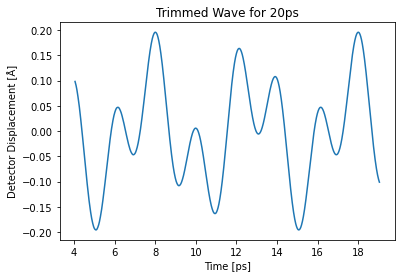

Windowed Wave


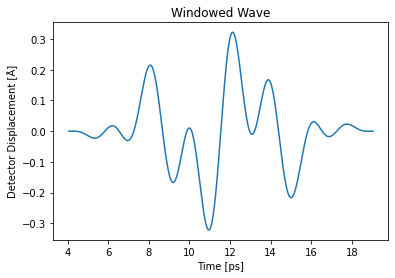

padded wave


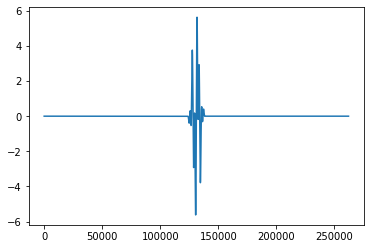


timeStep Δt is:
0.001
wave velocity v[m/s] is:
5523.494640827854
wave length λ1 is:
1.1046989281655708e-08


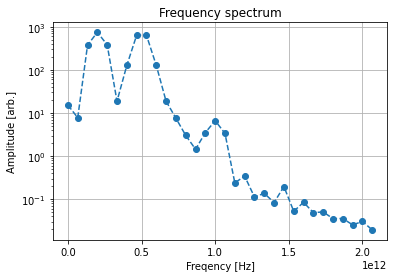

8.482115731036595e-12 9.964848244523351e-12 1.0120507281196401e-13 2.5046599603291873e-13
beta(SHG):
305.9351972086633
beta(FreqMix): f1-f2, f1+f2, ave 
[9.03755945 3.65178059 6.34467002]


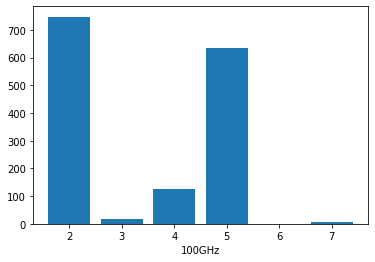

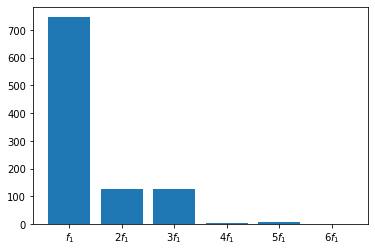

In [103]:
timeStep = data1[1, 0] - data1[0, 0]
time = data[:, 0]
x_detec = data[:, 2]
u_detec= x_detec - x_detec[0]
x_source = data[:, 1]
TLCM = 10
T1 = 2
T2 = 5
inputFreq1 = 10**12 / T1  # [Hz]
inputFreq2 = 10**12/T2
# wave amplitude at the source
source_amp = 0.1  # [Å]

Nc = 3

# Ns: Number of data points in one cycle
Ns = T2/timeStep

# N: Total Number of data points in thw windowed region
N = int(Nc*Ns)
plt.plot(data[:,1]-data[0,1])
plt.plot(u_detec)
plt.show()

zeroCrossTimeStep = getUpwardZeroCrossIndexFromArbitraryPoint(u_detec, 11000)
print(zeroCrossTimeStep)
plt.plot(u_detec)
plt.axvline(x=zeroCrossTimeStep,color="red")
plt.show()

arrivalTimeStep = int(zeroCrossTimeStep - TLCM/timeStep)
print(arrivalTimeStep)

windowStartTimeStep = int(arrivalTimeStep + T2/timeStep/2)
delta_x = x_detec[0] - x_source[0]

waveVelocity = delta_x*(10**(-10)) / ((arrivalTimeStep * timeStep)*(10**(-12)))
waveLength1 = waveVelocity * T1 * (10**(-12))
waveLength2 = waveVelocity * T2 * (10**(-12))


trimmedWave = trimAndOffset(x_detec, windowStartTimeStep, N)
trimmedTime = trim(time, windowStartTimeStep, N)
windowedWave = window(trimmedWave, "hann")
paddedWave = zeroPadding(windowedWave)
paddedWaveWithoutWindow = zeroPadding(trimmedWave)

##SUPER IMPORTANT##
waveToTransform = windowedWave
##CHOU DAIJI##

# FFT. transformedArray: [0]=power, [1]=freq
# FFTedData = fftWithWindow(trimmedWave, "hann") #window = "hann" or "hamming"
#FFTedData = fftWithWindow(zeroPadding(trimmedWave), "hann")
FFTedData = FFTonly(waveToTransform)
#FFTedData=FFTonly(window(trimmedWave, "hann"))
absFFTData = np.abs(FFTedData)

# higher harmonics amplitude[arb]
harmonicsIndex = getIndexUpToSixthHarmonic(absFFTData[1], inputFreq2)
A1 = absFFTData[0][harmonicsIndex[0]]
A2 = absFFTData[0][harmonicsIndex[1]]
A3 = absFFTData[0][harmonicsIndex[2]]
A4 = absFFTData[0][harmonicsIndex[3]]
A5 = absFFTData[0][harmonicsIndex[4]]
A6 = absFFTData[0][harmonicsIndex[5]]
Af1 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq1)]
Af2 = absFFTData[0][getIndexOfNearestValue(absFFTData[1], inputFreq2)]
Afsum = absFFTData[0][getIndexOfNearestValue(
    absFFTData[1], inputFreq1+inputFreq2)]
Afdif = absFFTData[0][getIndexOfNearestValue(
    absFFTData[1], inputFreq1-inputFreq2)]

af1_0 = source_amp*10**-10
af2_0 = source_amp*10**-10

af1 = Af1*2/int(len(waveToTransform))*10**-10
af2 = Af2*2/int(len(waveToTransform))*10**-10
asum = Afsum*2/int(len(waveToTransform))*10**-10
adif = Afdif*2/int(len(waveToTransform))*10**-10

a1s = source_amp*10**-10
a2 = 2*A2/int(len(waveToTransform))*10**-10

betaSHG = getBetaSHG(a1s, a2, waveLength2, delta_x*(10**-10))
"""with open("betaSHG.txt", "w") as f:
    f.write(str(betaSHG))
"""
betaFreqMix = getBetaFreqMix(
    asum, adif, af1_0, af2_0, inputFreq1, inputFreq2, delta_x*10**-10, waveVelocity)
"""with open("betaFreqMix.txt", "w") as f:
    f.write(str(betaFreqMix))
"""

# drawings
if HPC_OR_LOCAL == "LOCAL":
    fig = plt.figure()
    print("x_detec1")
    y = u_detec
    time_red = time[windowStartTimeStep:windowStartTimeStep+N]
    y_red = y[windowStartTimeStep:windowStartTimeStep+N]
    time1 = time[:windowStartTimeStep]
    y1 = y[:windowStartTimeStep]
    time2 = time[windowStartTimeStep+N:]
    y2 = y[windowStartTimeStep+N:]
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.plot(time, y)
    plt.plot(time_red,y_red, color ="red")
    plt.axvline(x=arrivalTimeStep*timeStep, color="green", linestyle="--")
    #plt.axvline(x=windowStartTimeStep*timeStep, color="red")
    #plt.axvline(x=(windowStartTimeStep+N)*timeStep, color="red")
    plt.show()


    print("timeStep Δt is:")
    print(timeStep)

    print("trimmed and offseted form of superimposed wave")
    plt.title("Trimmed Wave for 20ps")
    plt.plot(trimmedTime, trimmedWave)
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("Windowed Wave")
    plt.plot(trimmedTime, windowedWave)
    plt.title("Windowed Wave")
    plt.xlabel("Time [ps]")
    plt.ylabel("Detector Displacement [Å]")
    plt.show()

    print("padded wave")
    plt.plot(paddedWave)
    plt.show()


    print()
    print("timeStep Δt is:")
    print(timeStep)

    print("wave velocity v[m/s] is:")
    print(waveVelocity)

    print("wave length λ1 is:")
    print(waveLength1)

    fig, ax = plt.subplots()
    ax.set_yscale("log")
    #ax.plot(absFFTData[1,1:int(N/2)], absFFTData[0,1:int(N/2)])
    ax.plot(absFFTData[1, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4],
            absFFTData[0, 0:getIndexOfNearestValue(absFFTData[1], max(inputFreq1, inputFreq2))*4], marker="o", linestyle="--")
    ax.set_xlabel("Freqency [Hz]")
    ax.set_ylabel("Amplitude [arb.]")
    ax.grid()
    plt.title("Frequency spectrum")
    plt.show()

    print(af1, af2, asum, adif)

    print("beta(SHG):")
    print(betaSHG)

    print("beta(FreqMix): f1-f2, f1+f2, ave ")
    print(betaFreqMix)

    x_bar = np.array([inputFreq2, inputFreq1-inputFreq2,
                      inputFreq1, inputFreq1+inputFreq2, inputFreq2*2])
    y_bar = np.array([Af2, Afdif, Af1, Afsum, A2])
    x_bar = x_bar / 10**11
    plt.xlabel("100GHz")
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()

    x_bar = np.array(["$f_1$", "$2f_1$", "3$f_1$",
                      "4$f_1$", "5$f_1$", "6$f_1$"])
    y_bar = np.array([A1, A2, A3, A4, A5, A6])
    # print(x_bar)
    # print(y_bar)
    plt.bar(x_bar, y_bar)
    plt.show()



なんかFFT Duration伸ばしたら和成分減ったわ．
ところがどっこい，5ps周期*4周期分=20psの波動導入だから，中の15ps分をFFTしたんで，2psの500GHz成分が正しく抽出できないんだわな．
結局，lammpsscriptを25psで書き換えないといけないわ．